# Generative Adversarial Networks

Generative Adversarial Networks (GANs) are an approach to generative modeling based on deep learning methods.

The standard problem settings for GANs are generation of photorealistic images and image-to-image translation tasks (translating photos of summer to winter, day to night etc.).

In this task you will familiarize yourself with both these problems while trying to create fake images of sneakers. 

As GANs still do have certain limitations about generating large images, the task is decomposed into two: first, use a simple GAN to generate a bunch of low resolution images from noise, then upscale them using another generative model.

This notebook is built around [PyTorch](https://pytorch.org/) and [Lightning](https://pytorchlightning.ai/).

In [59]:
%%bash

if [ ! -d data/ ]; then
    wget "https://www.dropbox.com/s/7dnwfvqxstr3j4v/data.zip?dl=0" -O data.zip --quiet
    unzip -qq data.zip
fi

In [60]:
!pip install 'pytorch-lightning<1.8' --quiet

In [61]:
import os
import typing as tp

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import tqdm
from IPython.display import clear_output

%matplotlib inline

In [62]:
BATCH_SIZE = 128
MEDIUM_BATCH_SIZE = 64
SMALL_BATCH_SIZE = 4
IMAGE_SIZE = (28, 28)
NOISE_DIM = 100
LOW_RES_SIZE = IMAGE_SIZE
HIGH_RES_SIZE = (112, 112)

In [63]:
train_kwargs = {}
if torch.cuda.is_available():
    train_kwargs['gpus'] = torch.cuda.device_count()

In [64]:
dataset_root = "./data"
images_dir = "images"
image_filenames = sorted(os.listdir(os.path.join(dataset_root, images_dir)))
len(image_filenames)

5729

# I. Image Generation

Your first task is to solve a problem of generating photorealistic images out of noise (okay, this might sound optimistic).

Namely, you are required to **create fake images of sneakers of resolution 28x28 given a vector of noise sampled from standard normal distribution.**

Here is simple PyTorch `Dataset` class for loading and preprocessing

In [65]:
class SneakersDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            root_dir: str,
            images_dir='images',
            input_size: tp.Optional[tp.Tuple[int, int]] = None,
            target_size: tp.Optional[tp.Tuple[int, int]] = None
        ):
        self.images_dir = os.path.join(root_dir, images_dir)
        self.input_size = input_size
        self.target_size = target_size
        self.all_images = sorted(
            [
                fname for fname in os.listdir(self.images_dir)
                if fname.endswith('.jpg')
            ]
        )
    
    def __len__(self) -> int:
        return len(self.all_images)
    
    def __getitem__(self, idx: int) -> tp.Any:
        image_path = os.path.join(self.images_dir, self.all_images[idx])
        image_bgr = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        if self.input_size is not None:
            input_rgb = cv2.resize(image_rgb, self.input_size)
            input_rgb = (input_rgb / 255).astype(np.float32)
            
        if self.target_size is not None:
            image_rgb = cv2.resize(image_rgb, self.target_size)
        image_rgb = (image_rgb / 255).astype(np.float32)
        
        # tanh values in [-1, 1]
        if self.input_size is not None:
            return (
                torch.from_numpy(input_rgb * 2 - 1),
                torch.from_numpy(image_rgb * 2 - 1)
            )
        else:
            return torch.from_numpy(image_rgb * 2 - 1)

Here we create `LightningDataModule` which will handle dataset loading in our case

In [66]:
dataset = SneakersDataset(
    'data',
    target_size=IMAGE_SIZE
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

In [67]:
class SneakersGANDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size, shuffle=True):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def setup(self, stage=None):
        self.dataset = SneakersDataset(self.data_dir, target_size=IMAGE_SIZE)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle)

In [68]:
def data2img(d: np.ndarray):
    return 0.5 * d + 0.5

def visualize_images(
        data: tp.Iterable,
        n_rows: int,
        n_cols: int
    ) -> None:
    n_samples = n_rows * n_cols
    if len(data) != n_samples:
        sample_indices = np.random.choice(
            len(data),
            n_samples,
            replace=len(data) < n_samples
        )
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data2img(data[sample_index]))
        plt.axis("off")
    plt.show()

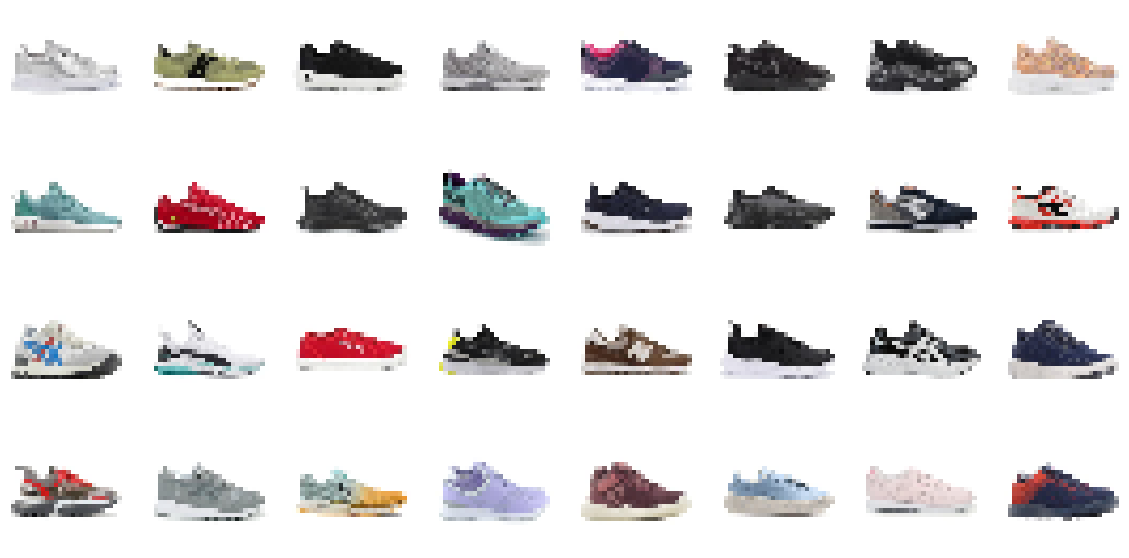

In [69]:
dm = SneakersGANDataModule('data', batch_size=32)
dm.setup()
visualize_images(next(iter(dm.train_dataloader())), 4, 8)

## Fully connected GAN

### Generator (0.5 pts) [cross-check:0]

Our first step is to build a generator. You should use the layers in `torch.nn` (imported in the beginning as `nn`) to construct the model. Since we are using PyTorch and Lightning, you should create `nn.Module`. Use the default initializers for parameters.

Architecture:
 * Fully connected (`Linear` in PyTorch) with output size of 1024
 * ReLU
 * Fully connected with output size of 1024
 * ReLU
 * Fully connected with output size of 28 x 28 x 3
 * TanH (to restrict every element of the output to be in the range [-1,1])
 * Reshape into (28, 28, 3)

> You could perform reshaping inside of `forward` method

In [70]:
class FCGenerator(torch.nn.Module):
    def __init__(
            self,
            noize_dim: int,
            img_shape: tp.Tuple[int, int]
        ):
        super().__init__()
        self._img_shape = img_shape
        
        self._model = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=noize_dim, 
                out_features=1024
            ),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(
                in_features=1024, 
                out_features=1024
            ),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(
                in_features=1024, 
                out_features=28 * 28 * 3
            ),
            torch.nn.Tanh()

        )
    
    def forward(self, z):
        img = self._model(z)
        img = img.view(img.size(0), *self._img_shape)  # keep batch size
        return img

In [71]:
fc_gen = FCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))
img_generated = fc_gen(torch.randn(32, NOISE_DIM))
assert img_generated.shape[1:] == IMAGE_SIZE + (3,)

### Discriminator (0.5 pts) [cross-check:1]

Now you are to build a discriminator. You should use the default initializers for parameters here as well.

Architecture:
 * Flatten
 * Fully connected with output size of 256
 * Leaky ReLU(0.01)
 * Fully connected with output size of 256
 * Leaky ReLU(0.01)
 * Fully connected with output size of 1
 * Sigmoid (to obtain logits as an output)

The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the probability that each of the `batch_size` inputs is a real image.

> You could perform flattening inside of `forward` method

In [72]:
class FCDiscriminator(torch.nn.Module):
    def __init__(self, img_shape: tp.Tuple[int, int]):
        super().__init__()
        self._model = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=np.prod(img_shape),
                out_features=256
            ),
            torch.nn.LeakyReLU(negative_slope=0.01),
            torch.nn.Linear(
                in_features=256,
                out_features=256
            ),
            torch.nn.LeakyReLU(negative_slope=0.01),
            torch.nn.Linear(
                in_features=256,
                out_features=1
            ),
            torch.nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self._model(img_flat)

In [73]:
fc_dis = FCDiscriminator(IMAGE_SIZE + (3,))
prob_dis = fc_dis(img_generated)
assert prob_dis.shape[1:] == (1,)

## GAN Loss (1.0 pts) [cross-check:2]

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Instead of computing the expectation, you may average over elements of the minibatch, so make sure to combine the loss by *averaging* instead of summing.

Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

There is a `LightningModule` with all necessary methods. You should fill all `TODO` comments.

> Don't forget to use `detach` method for discriminator training step to prevent backpropagation for generator compuational graph

In [74]:
# generator_loss = lambda p, t: torch.nn.BCELoss(reduction="mean")(p, t)
# discriminator_loss = lambda p, t: torch.nn.BCELoss(reduction="mean")(p, t)

In [75]:
fc_dis = FCDiscriminator(IMAGE_SIZE + (3,))
fc_gen = FCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))

loss = torch.nn.BCELoss(reduction="mean")
optimizer_dis = torch.optim.Adam(fc_dis.parameters(), lr=0.0001)
optimizer_gen = torch.optim.Adam(fc_gen.parameters(), lr=0.0001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fc_dis = fc_dis.to(device)
fc_gen = fc_gen.to(device)
device

device(type='cuda', index=0)

In [ ]:
# epoch_nums = 10

# fc_dis = fc_dis.eval()
# fc_gen = fc_gen.train()

# for epoch in range(epoch_nums):
#     for real_batch in dataloader:
#         optimizer_gen.zero_grad()

#         noize = torch.randn(BATCH_SIZE, NOISE_DIM)
#         noize = noize.to(device)
#         fake_batch = fc_gen(noize)
#         y = torch.ones(BATCH_SIZE, 1).to(device)
#         y_pred = fc_dis(fake_batch)
#         loss_value = -loss(y_pred, y)
#         loss_value.backward()
#         optimizer_gen.step()

#         X = torch.concat((real_batch, fake_batch))
#         y = torch.concat((torch.zeros(BATCH_SIZE, 1), torch.ones(BATCH_SIZE, 1)))
#         X = X.to(device)
#         y = y.to(device)
#         y_pred = fc_dis(X)
#         loss_value = loss(y_pred, y)        
    
#         print(epoch, loss_value.data, (y == (y_pred > 0.5).long()).cpu().numpy().mean())

In [ ]:
optimizer_indx = 0

In [ ]:
epoch_nums = 1000

for epoch in range(epoch_nums):
    optimizer_indx = epoch % 2
    for real_batch in dataloader:
        optimizer_dis.zero_grad()
        optimizer_gen.zero_grad()
        if optimizer_indx == 0:
            fc_gen = fc_gen.eval()
            fc_dis = fc_dis.train()
            noize = torch.randn(BATCH_SIZE, NOISE_DIM)
            noize = noize.to(device)
            fake_batch = fc_gen(noize).detach().cpu()
            X = torch.concat((real_batch, fake_batch))
            y = torch.concat((torch.zeros(BATCH_SIZE, 1), torch.ones(BATCH_SIZE, 1)))
            X = X.to(device)
            y = y.to(device)
            y_pred = fc_dis(X)
            loss_value = loss(y_pred, y)
            loss_value.backward()
            optimizer_dis.step()
        else:
            fc_dis = fc_dis.eval()
            fc_gen = fc_gen.train()
            noize = torch.randn(BATCH_SIZE, NOISE_DIM)
            noize = noize.to(device)
            fake_batch = fc_gen(noize)
            y = torch.ones(BATCH_SIZE, 1).to(device)
            y_pred = fc_dis(fake_batch)
            loss_value = -loss(y_pred, y)
            loss_value.backward()
            optimizer_gen.step()
        print(epoch, 1 - optimizer_indx, loss_value.data, (y == (y_pred > 0.5).long()).cpu().numpy().mean())

    # optimizer_indx = 1 - optimizer_indx

        if optimizer_indx == 0 and np.isclose((y == (y_pred > 0.5).long()).cpu().numpy().mean(), 1.0):
            optimizer_indx = 1 - optimizer_indx
        elif optimizer_indx == 1 and np.isclose((y == (y_pred > 0.5).long()).cpu().numpy().mean(), 0.0):
            optimizer_indx = 1 - optimizer_indx
    

In [ ]:
# class FCGAN(pl.LightningModule):
#     def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
#         super().__init__()
#         self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
#         img_shape = (width, height, channels)
#         self.generator = FCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape)
#         self.discriminator = FCDiscriminator(img_shape=img_shape)
        
#         self.validation_z = torch.randn(8, noise_dim)
    
#     def forward(self, z):
#         return self.generator(z)
    
#     def gan_loss(self, y_hat, y):
#         return  # TODO: implement GAN loss (hint: binary cross entropy)
    
#     def training_step(self, imgs, batch_idx, optimizer_idx):
#         z = torch.randn(imgs.size(0), self.hparams.noise_dim)
#         z = z.type_as(imgs)  # move to same device as imgs
        
#         if optimizer_idx == 0:  # generator
#             self.generated_imgs = self(z)
            
#             valid = torch.ones(imgs.size(0), 1)  # all fake, but we want to be real
#             valid = valid.type_as(imgs)
            
#             g_loss = self.gan_loss(self.discriminator(self(z)), valid)
#             self.log('g_loss', g_loss, prog_bar=True)
#             return {'loss': g_loss}
        
#         if optimizer_idx == 1:  # discriminator
#             valid = torch.ones(imgs.size(0), 1)
#             valid = valid.type_as(imgs)
#             real_loss = # TODO: loss for `discriminator(imgs)` and `valid`
            
#             fake = # TODO: zero vector for fake_loss computation
#             fake = fake.type_as(imgs)

#             fake_loss = self.gan_loss(self.discriminator(self(z).detach()), fake)
            
#             d_loss = (real_loss + fake_loss) / 2
#             self.log('d_loss', d_loss, prog_bar=True)
#             return {'loss': d_loss}
    
#     def configure_optimizers(self):
#         lr = self.hparams.lr
#         b1 = self.hparams.b1
#         b2 = self.hparams.b2

#         opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
#         opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
#         return [opt_g, opt_d], []

#     def on_epoch_end(self):
#         # send results for validation_z to TensorBoard
#         z = self.validation_z.type_as(self.generator.model[0].weight)
#         sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

#### Training

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [ ]:
# train_kwargs['max_epochs'] = 100

In [ ]:
# dm = SneakersGANDataModule('data', batch_size=BATCH_SIZE)
# model = FCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
# trainer = pl.Trainer(**train_kwargs)
# trainer.fit(model, dm)

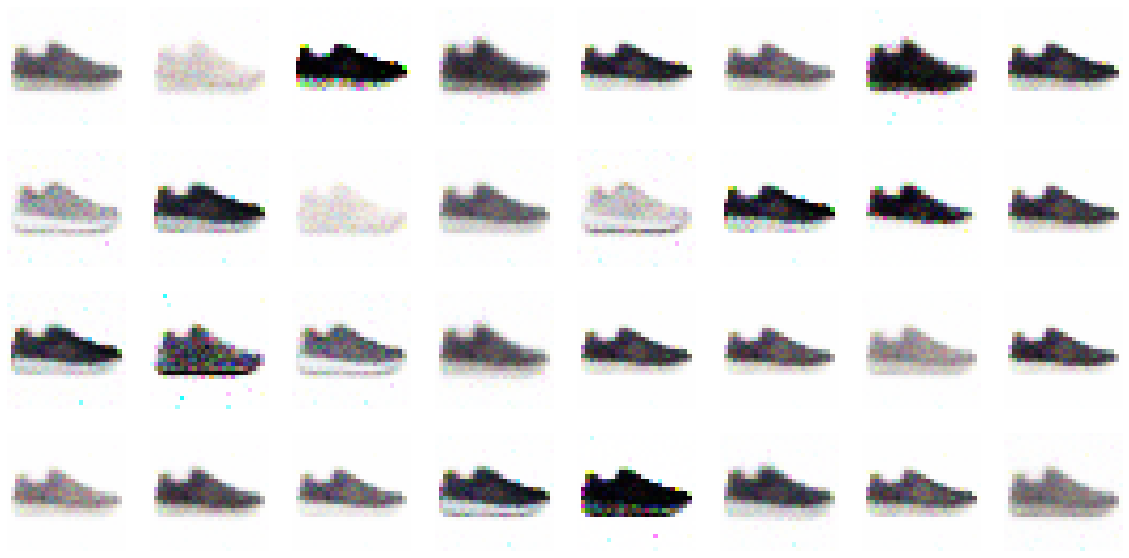

In [ ]:
visualize_images(fc_gen(torch.randn(32, NOISE_DIM).to(device)).cpu().detach(), 4, 8)

> Hint: this architecture isn't great, so don't spend all your time to train it

## Deep Convolutional GANs
In the first part of the notebook, you have implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, you are to implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where both discriminator and generator are convolutional networks.

### Generator (1.0 pts) [cross-check:3]

Architecture:
 * Fully connected with output size of 128x7x7
 * Reshape into (128, 7, 7)
 * ReLU
 * UpSampling2D(2)
 * Conv2D: 3x3, filters=128, padding="same"
 * Batch Normalization 2D with momentum(0.8)
 * ReLU
 * UpSampling2D(2)
 * Conv2D: 3x3, filters=64, padding="same"
 * Batch Normalization 2D with momentum(0.8)
 * ReLU
 * Conv2D: 3x3, filters=3, padding="same"
 * TanH (to restrict every element of the output to be in the range [-1,1])
 
> There is no `padding="same"` in PyTorch, but you could use `padding=k//2` and `padding_mode="zeros"` for kernel size `k`

In [76]:
class DCGenerator(torch.nn.Module):
    def __init__(
            self,
            noise_dim: int,
            img_shape: tp.Tuple[int, int]
        ):
        super().__init__()
        self._img_shape = img_shape

        self._first_fc = torch.nn.Linear(
           in_features=noise_dim,
           out_features=128 * 7 * 7
        )
        
        self._model = torch.nn.Sequential(
            torch.nn.ReLU(inplace=True),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=64,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(
                num_features=64,
                momentum=0.8
            ),
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.BatchNorm2d(
                num_features=64,
                momentum=0.8
            ),            
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=3,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.Tanh()
        )
    
    def forward(self, z):
        img = self._first_fc(z)
        img = img.view(img.size(0), 128, 7, 7)  # keep batch size
        img = self._model(img)
        img = img.permute(0, 2, 3, 1)  # make channel axis last
        return img

In [77]:
dc_gen = DCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))
fake_imgs = dc_gen(torch.randn(10, NOISE_DIM))
assert fake_imgs.shape[1:] == IMAGE_SIZE + (3,)

### Discriminator (1.0 pts) [cross-check:4]

Architecture:
 * Conv2D: 3x3, filters=32, strides=2, padding="same"
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=64, strides=2, padding="same"
 * Zero Padding 2D: ((0, 1), (0, 1))
 * Batch Normalization 2D with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=128, strides=2, padding="same"
 * Batch Normalization 2D with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=256, strides=2, padding="same"
 * Batch Normalization 2D with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Flatten
 * Fully connected layer with output size 1
 * Sigmoid

In [78]:
class DCDiscriminator(torch.nn.Module):
    def __init__(self, img_shape: tuple):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=(3, 3),
                stride=(2, 2),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Dropout(p=0.25),
            torch.nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3, 3),
                stride=(2, 2),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.ZeroPad2d(padding=(0, 1, 0, 1)),
            torch.nn.BatchNorm2d(
                num_features=64,
                momentum=0.8
            ),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Dropout(p=0.25),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=(3, 3),
                stride=(2, 2),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.BatchNorm2d(
                num_features=128,
                momentum=0.8
            ),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Dropout(p=0.25),
            torch.nn.Flatten(),
            torch.nn.Linear(
                in_features=128 * 4 * 4,
                out_features=1
            ),
            torch.nn.Sigmoid()
        )
    
    def forward(self, img):
        img_chan = img.permute(0, 3, 1, 2)  # channels first
        return self.model(img_chan)

In [79]:
dc_dis = DCDiscriminator(img_shape=IMAGE_SIZE + (3,))
fake_proba = dc_dis(fake_imgs)
assert fake_proba.shape[1:] == (1,)

## Least Squares GAN loss (1.0 pts) [cross-check:5]
We'll now look at [Least Squares GAN loss](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all you have to do is change the loss function and retrain the model. You'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [80]:
loss_dis = lambda y_pred, y: (
    -(
        torch.log(y_pred[y == 1]) +
        torch.log((1 - y_pred[y == 0]))
    ) * 0.5
).mean()

loss_gen = lambda y_pred, y: -torch.log(1 - y_pred[y == 1]).mean()

In [81]:
loss_dis = lambda y_pred, y: (
    -(
        torch.log(y_pred[y == 1] ** 2) +
        torch.log((1 - y_pred[y == 0])**2)
    ) * 0.5
).mean()

loss_gen = lambda y_pred, y: -torch.log((1 - y_pred[y == 1]) ** 2).mean()

In [82]:
loss_dis = lambda y_pred, y: (y_pred[y == 1] ** 2 + (1 - y_pred[y == 0])**2).mean() * 0.5
loss_gen = lambda y_pred, y: ((1 - y_pred[y == 1]) ** 2).mean() * 0.5

In [83]:
# class DCGAN(pl.LightningModule):
#     def __init__(self, width, height, channels, noise_dim=100, lr=0.0002, b1=0.5, b2=0.999):
#         super().__init__()
#         self.save_hyperparameters()  # make <arg> available as self.hparams.<arg>
        
#         img_shape = (width, height, channels)
#         self.generator = DCGenerator(noise_dim=self.hparams.noise_dim, img_shape=img_shape)
#         self.discriminator = DCDiscriminator(img_shape=img_shape)
        
#         self.validation_z = torch.randn(8, noise_dim)
        
#     def forward(self, z):
#         return self.generator(z)
    
#     def ls_loss(self, y_hat, y):
#         return  # TODO: implement least squares GAN loss
    
#     def training_step(self, imgs, batch_idx, optimizer_idx):
#         z = torch.randn(imgs.size(0), self.hparams.noise_dim)
#         z = z.type_as(imgs)  # move to same device as imgs
        
#         if optimizer_idx == 0:  # generator
#             # TODO: compute loss as before (FCGAN)
            
#             self.log('g_loss', g_loss, prog_bar=True)
#             return {'loss': g_loss}
        
#         if optimizer_idx == 1:  # discriminator
#             # TODO: compute loss as before (FCGAN)
            
#             self.log('d_loss', d_loss, prog_bar=True)
#             return {'loss': d_loss}
    
#     def configure_optimizers(self):
#         lr = self.hparams.lr
#         b1 = self.hparams.b1
#         b2 = self.hparams.b2

#         opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
#         opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
#         return [opt_g, opt_d], []

#     def on_epoch_end(self):
#         z = self.validation_z.type_as(self.generator.model[0].weight)
#         sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

### Training
Train generator and discriminator in a loop and draw results once every N iterations.

In [86]:
dl_dis = DCDiscriminator(IMAGE_SIZE + (3,))
dl_gen = DCGenerator(NOISE_DIM, IMAGE_SIZE + (3,))

loss = torch.nn.BCELoss(reduction="mean")
optimizer_dis = torch.optim.Adam(dl_dis.parameters(), lr=0.0001)
optimizer_gen = torch.optim.Adam(dl_gen.parameters(), lr=0.0001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dl_dis = dl_dis.to(device)
dl_gen = dl_gen.to(device)
device

device(type='cuda', index=0)

In [120]:
epoch_nums = 150  # 500

dl_dis = dl_dis.to(device)
dl_gen = dl_gen.to(device)

for epoch in range(epoch_nums):
    optimizer_indx = epoch % 2
    for real_batch in dataloader:
        optimizer_dis.zero_grad()
        optimizer_gen.zero_grad()
        if optimizer_indx == 0:
            dl_gen = dl_gen.eval()
            dl_dis = dl_dis.train()
            noize = torch.randn(BATCH_SIZE, NOISE_DIM)
            noize = noize.to(device)
            fake_batch = dl_gen(noize).detach().cpu()
            X = torch.concat((real_batch, fake_batch))
            y = torch.concat((torch.zeros(BATCH_SIZE, 1), torch.ones(BATCH_SIZE, 1)))
            X = X.to(device)
            y = y.to(device)
            y_pred = dl_dis(X)
            loss_value = loss_dis(y_pred, y)
            loss_value.backward()
            optimizer_dis.step()
        else:
            dl_dis = dl_dis.eval()
            dl_gen = dl_gen.train()
            noize = torch.randn(BATCH_SIZE, NOISE_DIM)
            noize = noize.to(device)
            fake_batch = dl_gen(noize)
            y = torch.ones(BATCH_SIZE, 1).to(device)
            y_pred = dl_dis(fake_batch)
            loss_value = loss_gen(y_pred, y)            
            loss_value.backward()
            optimizer_gen.step()
        print(epoch, 1 - optimizer_indx, loss_value.data, (y == (y_pred > 0.5).long()).cpu().numpy().mean())

        optimizer_indx = 1 - optimizer_indx

        # if optimizer_indx == 0 and np.isclose((y == (y_pred > 0.5).long()).cpu().numpy().mean(), 1.0):
        #     optimizer_indx = 1 - optimizer_indx
        # elif optimizer_indx == 1 and np.isclose((y == (y_pred > 0.5).long()).cpu().numpy().mean(), 0.0):
        #     optimizer_indx = 1 - optimizer_indx
    

0 1 tensor(0.1482, device='cuda:0') 0.16796875
0 0 tensor(0.3715, device='cuda:0') 0.0
0 1 tensor(0.1309, device='cuda:0') 0.16015625
0 0 tensor(0.3573, device='cuda:0') 0.0
0 1 tensor(0.1398, device='cuda:0') 0.1953125
0 0 tensor(0.3680, device='cuda:0') 0.0
0 1 tensor(0.1507, device='cuda:0') 0.1796875
0 0 tensor(0.3558, device='cuda:0') 0.0
0 1 tensor(0.1347, device='cuda:0') 0.1796875
0 0 tensor(0.3562, device='cuda:0') 0.0
0 1 tensor(0.1374, device='cuda:0') 0.1796875
0 0 tensor(0.3633, device='cuda:0') 0.0
0 1 tensor(0.1213, device='cuda:0') 0.1640625
0 0 tensor(0.3703, device='cuda:0') 0.0078125
0 1 tensor(0.1297, device='cuda:0') 0.15234375
0 0 tensor(0.3580, device='cuda:0') 0.0
0 1 tensor(0.1207, device='cuda:0') 0.1328125
0 0 tensor(0.3653, device='cuda:0') 0.0
0 1 tensor(0.1218, device='cuda:0') 0.1484375
0 0 tensor(0.3683, device='cuda:0') 0.0
0 1 tensor(0.0929, device='cuda:0') 0.08984375
0 0 tensor(0.3670, device='cuda:0') 0.0
0 1 tensor(0.0990, device='cuda:0') 0.109375

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [ ]:
# train_kwargs['max_epochs'] = 100

In [ ]:
# dm = SneakersGANDataModule('data', batch_size=BATCH_SIZE)
# model = DCGAN(*IMAGE_SIZE, 3, NOISE_DIM)
# trainer = pl.Trainer(**train_kwargs)
# trainer.fit(model, dm)

Prepare data for **III. GAN metrics. PRD score**:

In [47]:
import tqdm

def predict(
        model: torch.nn.Module,
        data: torch.Tensor,
        batch_size: int,
        verbose: bool = True
) -> torch.Tensor:
    output = []
    slicer = range(0, len(data), batch_size)
    if verbose:
        slicer = tqdm.tqdm(slicer)

    model.eval()
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        model.cuda()
    with torch.no_grad():
        for i in slicer:
            x = data[i:i + batch_size]
            if use_gpu:
                x = x.cuda()
            y = model(x)
            if use_gpu:
                y = y.cpu()
            output.append(y)
    if use_gpu:
        model.cpu()
        
    output = torch.cat(output, dim=0)
    return output

In [122]:
dataset = SneakersDataset('data', target_size=IMAGE_SIZE)
lr_data = torch.stack([dataset[i] for i in range(len(dataset))], dim=0)
dc_fake_data = predict(dl_gen, torch.randn(lr_data.size(0), NOISE_DIM), BATCH_SIZE)
print('LR data:', lr_data.size())
print('Fake LR data:', dc_fake_data.size())

100%|██████████| 45/45 [00:00<00:00, 67.15it/s]

LR data: torch.Size([5729, 28, 28, 3])
Fake LR data: torch.Size([5729, 28, 28, 3])


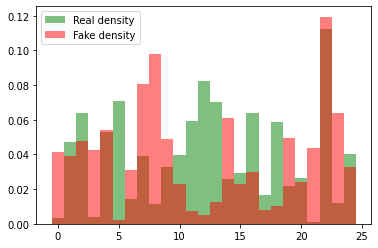

Score: 2.132742746596679e-06


In [123]:
score,  _, _ = calculate_prd_score(lr_data, dc_fake_data)
print("Score:", score)

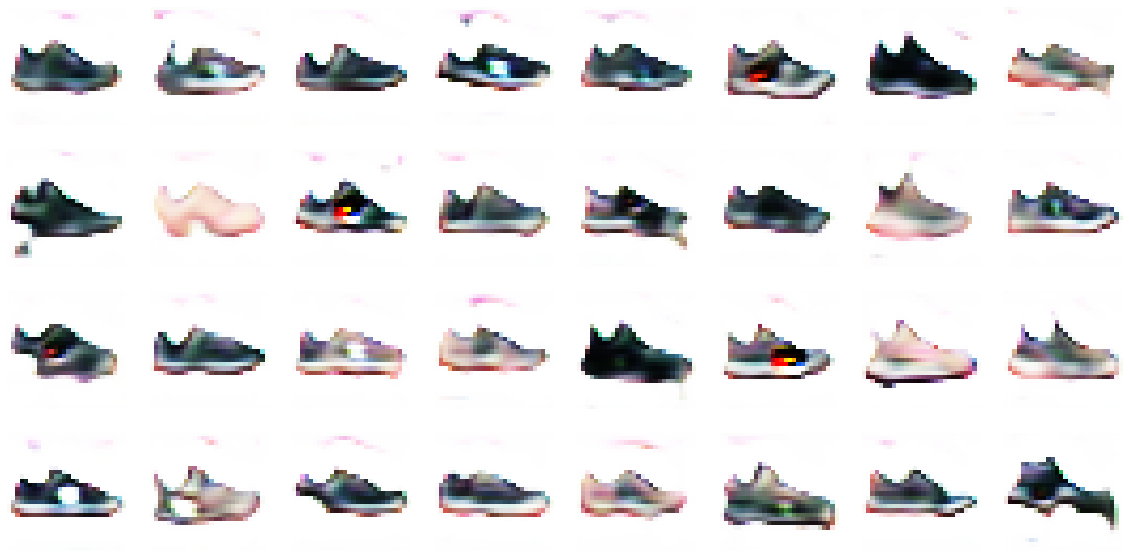

In [124]:
visualize_images(dl_gen(torch.randn(32, NOISE_DIM)).cpu().detach(), 4, 8)

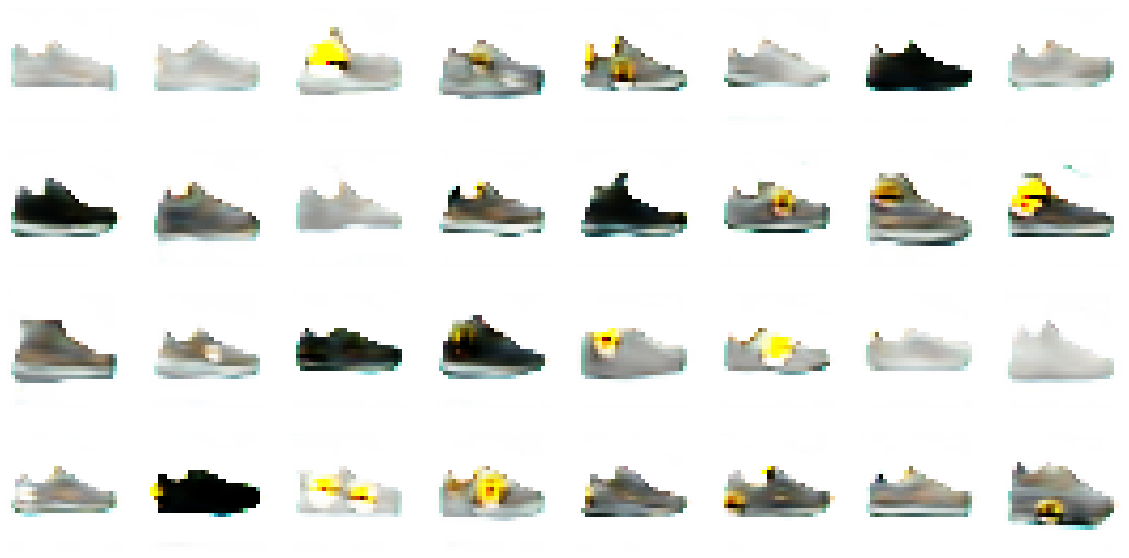

In [ ]:
visualize_images(dl_gen(torch.randn(32, NOISE_DIM).to(device)).cpu().detach(), 4, 8)

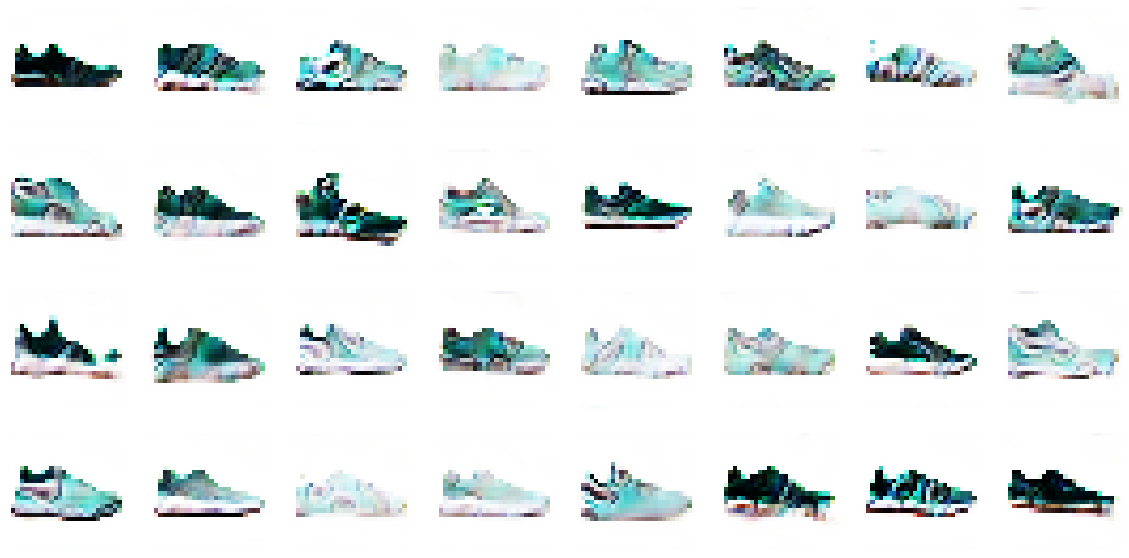

In [ ]:
visualize_images(dl_gen(torch.randn(32, NOISE_DIM).to(device)).cpu().detach(), 4, 8)

# II. Super Resolution

In this part of the notebook you will train a generative model that solves an image-to-image problem, with "small images" as a source domain and "large images" being a target domain. 

To specify the task, you are to **scale small images of 28x28 pixels up to size of 112x112 pixels**.

In [9]:
# class SneakersSRDataModule(pl.LightningDataModule):
#     def __init__(self, data_dir: str, batch_size, shuffle=True):
#         super().__init__()
#         self.data_dir = data_dir
#         self.batch_size = batch_size
#         self.shuffle = shuffle
    
#     def setup(self, stage=None):
#         self.dataset = SneakersDataset(self.data_dir, input_size=LOW_RES_SIZE, target_size=HIGH_RES_SIZE)
    
#     def train_dataloader(self):
#         return torch.utils.data.DataLoader(self.dataset, batch_size=self.batch_size, shuffle=self.shuffle)

In [10]:
dataset = SneakersDataset(
    "data",
    input_size=LOW_RES_SIZE,
    target_size=HIGH_RES_SIZE
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=True
)

In [116]:
real_data_lr, real_data_hr = next(iter(dataloader))

assert real_data_lr.shape[1:] == LOW_RES_SIZE + (3,)
assert real_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

plt.figure(figsize=(8, 14))
for i in range(SMALL_BATCH_SIZE):
    plt.subplot(SMALL_BATCH_SIZE, 2, 2 * i + 1)
    plt.title("Low resolution")
    plt.imshow(data2img(real_data_lr[i]))
    plt.axis("off")

    plt.subplot(SMALL_BATCH_SIZE, 2, 2 * i + 2)
    plt.title("High resolution")
    plt.imshow(data2img(real_data_hr[i]))
    plt.axis("off")

plt.show()

ValueError: ignored

In the second part of this task, you are to train an [SRGAN](https://arxiv.org/abs/1609.04802)-like model. For your convinience, some layers are already implemented. Now it's your turn -- fill the gaps so the model passes the asserts below.

### Generator (1.5 pts) [cross-check:6]

To build a SRGAN Generator, you will need a basic Residual Block(filters):

* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* ReLU
* Batch Normalization 2D with momentum(0.8)
* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* Batch Normalization 2D with momentum(0.8)
* Sum up outputs with inputs


In [12]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, filters: int):
        super().__init__()
        self._model = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=filters,
                out_channels=filters,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.ReLU(inplace=True),
            torch.nn.BatchNorm2d(
                num_features=filters,
                momentum=0.8
            ),
            torch.nn.Conv2d(
                in_channels=filters,
                out_channels=filters,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.BatchNorm2d(
                num_features=filters,
                momentum=0.8
            )
        )
        
    def forward(self, z):
        zc = self._model(z)
        return zc + z

Upsampling Block(filters):

* UpSampling2D(2)
* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* ReLU


In [13]:
class UpsamplingBlock(torch.nn.Module):
    def __init__(
            self,
            filters: int,
            input_filters: tp.Optional[int] = None
    ):
        super().__init__()
        input_filters = filters if input_filters is None else input_filters
        self._model = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.Conv2d(
                in_channels=input_filters,
                out_channels=filters,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.ReLU(inplace=True)
        )
        
    def forward(self, z):
        return self._model(z)

Now, using these basic building blocks, one is able to define a SRGAN generator:

In [14]:
class SRGenerator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self._init_conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=9, padding=9 // 2, padding_mode='zeros'),
            torch.nn.ReLU(inplace=True)
        )
        self._residual_chain = torch.nn.Sequential(
            *[ResidualBlock(64) for _ in range(16)],
            torch.nn.Conv2d(64, 64, kernel_size=3, padding=3 // 2, padding_mode='zeros'),
            torch.nn.BatchNorm2d(64, momentum=0.8)
        )
        self._upsample_conv = torch.nn.Sequential(
            UpsamplingBlock(256, input_filters=64),
            UpsamplingBlock(256),
            torch.nn.Conv2d(256, 3, kernel_size=9, padding=9 // 2, padding_mode='zeros'),
            torch.nn.Tanh()
        )
    
    def forward(self, z):
        x = z.permute(0, 3, 1, 2)
        conv = self._init_conv(x)
        x = self._residual_chain(conv) + conv
        img = self._upsample_conv(x)
        img = img.permute(0, 2, 3, 1)  # make channel axis last
        return img

In [15]:
# real_data_lr, real_data_hr = next(iter(dm.train_dataloader()))
real_data_lr, real_data_hr = next(iter(dataloader))
fake_hr = SRGenerator()(real_data_lr)
assert fake_hr.shape == real_data_hr.shape

### Discriminator (1.5 pts) [cross-check:7]

First, define a Discriminator Block(filters, strides):

* Conv2D: 3x3, filters=filters, strides=strides, padding="same"
* Leaky ReLU(0.2)
* (optional) Batch Normalization 2D with momentum(0.8) 

In [16]:
class DBlock(torch.nn.Module):
    def __init__(
            self, 
            input_filters: int,
            filters: int,
            strides: tp.Tuple[int, int],
            batch_norm: bool = False
    ):
        super().__init__()
        layers = [
            torch.nn.Conv2d(
                in_channels=input_filters,
                out_channels=filters,
                kernel_size=(3, 3),
                stride=strides,
                padding=(1, 1),
                padding_mode="zeros"
            ),
            torch.nn.LeakyReLU(negative_slope=0.2)
        ]
        if batch_norm:
            layers.append(torch.nn.BatchNorm2d(filters, momentum=0.8))
        self._model = torch.nn.Sequential(*layers)
    
    def forward(self, z):
        return self._model(z)

Now, use this block to build up SRGAN discriminator:

* DBlock(filters=64, strides=1) with Batch Normalization
* DBlock(filters=64, strides=2)
* DBlock(filters=128, strides=1)
* DBlock(filters=128, strides=2)
* DBlock(filters=256, strides=1)
* DBlock(filters=256, strides=2)
* DBlock(filters=512, strides=1)
* DBlock(filters=512, strides=2)
* Flatten
* Fully connected with output size of 1024
* Leaky ReLU(0.2)
* Fully connected with output size of 1
* Sigmoid

In [17]:
class Flatten(torch.nn.Module):
    def forward(self, x: torch.Tensor):
        return x.flatten(1)

class SRDiscriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._model = nn.Sequential(
            DBlock(3, 64, strides=(1, 1), batch_norm=True),  # out: 64x112x112
            DBlock(64, 64, strides=(2, 2)),  # out: 64x56x56 
            DBlock(64, 128, strides=(1, 1)),  # out: 128x56x56
            DBlock(128, 128, strides=(2, 2)),  # out: 128x28x28
            DBlock(128, 256, strides=(1, 1)),  # out: 256x28x28
            DBlock(256, 256, strides=(2, 2)),  # out: 256x14x14
            DBlock(256, 512, strides=(1, 1)),  # out: 512x14x14
            DBlock(512, 512, strides=(2, 2)),  # out: 512x7x7
            Flatten(),  # out: 25088
            torch.nn.Linear(25088, 1024),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Linear(1024, 1),
            torch.nn.Sigmoid()
        )
    
    def forward(self, z):
        x = z.permute(0, 3, 1, 2)
        return self._model(x)

In [18]:
fake_probas = SRDiscriminator()(fake_hr)
assert fake_probas.shape[1:] == (1,)

Typically, SRGAN is trained with additional loss on features from pretrained VGG-19. However, you task will be a bit simplier: use **mean squared error** between real and fake data instead.

In [19]:
# class SRGAN(pl.LightningModule):
#     def __init__(self, validation_lr):
#         super().__init__()
        
#         self.generator = SRGenerator()
#         self.discriminator = SRDiscriminator()

#         self.validation_lr = validation_lr
        
#     def forward(self, z):
#         return self.generator(z)
    
#     def gan_loss(self, y_hat, y):
#         return  # TODO: implement loss
    
#     def ls_loss(self, y_hat, y):
#         return  # TODO: implement loss
    
#     def mse_loss(self, sr_imgs, hr_imgs):
#         return  # TODO: implement MSE loss
    
#     def training_step(self, imgs, batch_idx, optimizer_idx):
#         lr_imgs, hr_imgs = imgs
        
#         if optimizer_idx == 0:  # generator
#             sr_imgs = self(lr_imgs)
            
#             valid = torch.ones(lr_imgs.size(0), 1)  # all fake, but we want to be real
#             valid = valid.type_as(lr_imgs)
            
#             gan_loss = self.gan_loss(self.discriminator(sr_imgs), valid)
#             mse_loss = self.mse_loss(sr_imgs, hr_imgs)
            
#             g_loss = 1 * mse_loss + 0.5 * gan_loss
#             self.log('g_loss', g_loss, prog_bar=True)
#             self.log('gan_loss', gan_loss, prog_bar=True)
#             self.log('mse_loss', mse_loss, prog_bar=True)
#             return g_loss
        
#         if optimizer_idx == 1:  # discriminator
#             valid = torch.ones(hr_imgs.size(0), 1)
#             valid = valid.type_as(hr_imgs)
#             real_loss = self.ls_loss(self.discriminator(hr_imgs), valid)
            
#             fake = torch.zeros(lr_imgs.size(0), 1)
#             fake = fake.type_as(lr_imgs)
#             fake_loss = self.ls_loss(self.discriminator(self(lr_imgs).detach()), fake)
            
#             d_loss = (real_loss + fake_loss) / 2
#             self.log('d_loss', d_loss, prog_bar=True)
#             return d_loss
    
#     def configure_optimizers(self):
#         opt_g = torch.optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
#         opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
#         return [opt_g, opt_d], []

#     def on_epoch_end(self):
#         z = self.validation_lr.type_as(self.generator.init_conv[0].weight)
#         sample_imgs = self(z).permute(0, 3, 1, 2)  # channels before pixels
#         grid = torchvision.utils.make_grid(sample_imgs)
#         self.logger.experiment.add_image('generated_images', grid, self.current_epoch)

### Training

In [20]:
batch_size = BATCH_SIZE

dataset = SneakersDataset(
    "data",
    input_size=LOW_RES_SIZE,
    target_size=HIGH_RES_SIZE
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

batch_size

128

In [21]:
loss_dis = lambda y_pred, y: (
    -(
        torch.log(y_pred[y == 1]) +
        torch.log((1 - y_pred[y == 0]))
    ) * 0.5
).mean()

loss_gen = lambda y_pred, y: -(-torch.log(y_pred[y == 1]).mean())
# loss_gen = lambda y_pred, y: -torch.log(1 - y_pred[y == 1]).mean()

In [22]:
srgan_dis = SRDiscriminator()
srgan_gen = SRGenerator()

# loss_dis = lambda y_pred, y: (y_pred[y == 1] ** 2 + (1 - y_pred[y == 0])**2).mean() * 0.5
# loss_gen = lambda y_pred, y: ((1 - y_pred[y == 1]) ** 2).mean() * 0.5
loss_mse = torch.nn.MSELoss()

optimizer_dis = torch.optim.Adam(srgan_dis.parameters(), lr=0.0001)
optimizer_gen = torch.optim.Adam(srgan_gen.parameters(), lr=0.0001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
srgan_dis = srgan_dis.to(device)
srgan_gen = srgan_gen.to(device)
device

device(type='cuda', index=0)

In [ ]:
epoch_nums = 80

for epoch in range(epoch_nums):
    optimizer_indx = epoch % 2
    for X, Y_real in dataloader:
        X = X.to(device)
        optimizer_dis.zero_grad()
        optimizer_gen.zero_grad()
        if optimizer_indx == 0:
            srgan_gen = srgan_gen.eval()
            srgan_dis = srgan_dis.train()
            Y_fake = srgan_gen(X).detach().cpu()
            X = torch.concat((Y_real, Y_fake))
            y = torch.concat((torch.zeros(batch_size, 1), torch.ones(batch_size, 1)))
            X = X.to(device)
            y = y.to(device)
            y_pred = srgan_dis(X)
            loss_value = loss_dis(y_pred, y)
            loss_value.backward()
            optimizer_dis.step()
        else:
            srgan_dis = srgan_dis.eval()
            srgan_gen = srgan_gen.train()
            Y_fake = srgan_gen(X)
            y = torch.ones(batch_size, 1).to(device)
            y_pred = srgan_dis(Y_fake)
            Y_real = Y_real.to(device)
            loss_value = loss_gen(y_pred, y) * 0.001 + loss_mse(Y_fake, Y_real)          
            loss_value.backward()
            optimizer_gen.step()
        print(epoch, 1 - optimizer_indx, loss_value.data, (y == (y_pred > 0.5).long()).cpu().numpy().mean())

        optimizer_indx = 1 - optimizer_indx

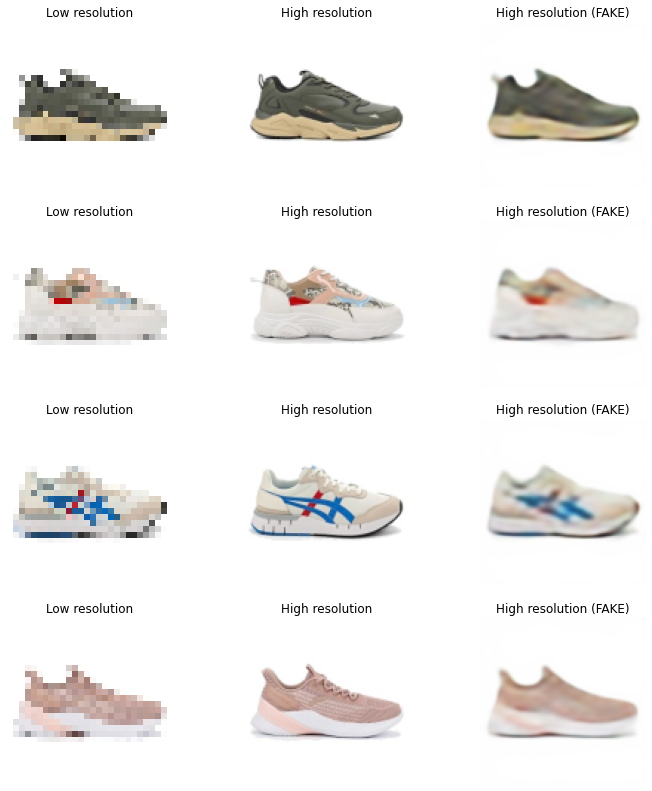

In [ ]:
N = 4
real_data_lr, real_data_hr = next(iter(dataloader))
fake_data_hr = srgan_gen.eval()(real_data_lr.to(device)).detach().cpu()

real_data_lr = real_data_lr[:N]
real_data_hr = real_data_hr[:N]
fake_data_hr = fake_data_hr[:N]

plt.figure(figsize=(12, 14))
for i in range(SMALL_BATCH_SIZE):
    plt.subplot(SMALL_BATCH_SIZE, 3, 3 * i + 1)
    plt.title("Low resolution")
    plt.imshow(data2img(real_data_lr[i]))
    plt.axis("off")

    plt.subplot(SMALL_BATCH_SIZE, 3, 3 * i + 2)
    plt.title("High resolution")
    plt.imshow(data2img(real_data_hr[i]))
    plt.axis("off")

    plt.subplot(SMALL_BATCH_SIZE, 3, 3 * i + 3)
    plt.title("High resolution (FAKE)")
    plt.imshow(data2img(fake_data_hr[i]))
    plt.axis("off")

plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [ ]:
# train_kwargs['max_epochs'] = 9

In [ ]:
# dm = SneakersSRDataModule('data', batch_size=16)
# dm.setup()
# model = SRGAN(validation_lr=next(iter(dm.train_dataloader()))[0][:4])
# trainer = pl.Trainer(**train_kwargs)
# trainer.fit(model, dm)

Prepare data for **III. GAN metrics**:

In [23]:
# dm = SneakersSRDataModule('data', batch_size=BATCH_SIZE)
# dm.setup()
# hr_data = []
# for lr, hr in dm.train_dataloader():
#     hr_data.append(hr)
# hr_data = torch.cat(hr_data, dim=0)

# batch_size = 16
# sr_fake_data_from_real_lr = predict(model, lr_data, batch_size)
# sr_fake_data_from_fake_lr = predict(model, dc_fake_data, batch_size)
# print('HR data:', hr_data.size())
# print('SR from real LR:', sr_fake_data_from_real_lr.size())
# print('SR from fake LR:', sr_fake_data_from_fake_lr.size())

In [24]:
# visualize_images(sr_fake_data_from_real_lr, 4, 8)

In [25]:
# visualize_images(sr_fake_data_from_fake_lr, 4, 8)

# III. GAN metrics

There exists a few metrics used to measure GAN performance. Some of them are based on comparing real samples against generated ones, while the other rely on additional pretrained models that are applied to both real and generated data in order to accumulate high-level statistics. In this task, you are going to use two metrics representing these two approaches -- namely, [Precision-Recall Density](https://arxiv.org/pdf/1806.00035) and [Fréchet Inception Distance](https://arxiv.org/pdf/1706.08500).

##  Precision-Recall Density (PRD score) (1.0 pts) [cross-check:8]

Your first task is to implement [Precision-Recall Density](https://arxiv.org/pdf/1806.00035.pdf) score.

In [113]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def bin_counts(
        real_data: np.array,
        fake_data: np.array,
        n_bins: int = 25
) -> tp.Tuple[np.array, np.array]:
    real_data = real_data.reshape(len(real_data), -1)
    fake_data = fake_data.reshape(len(fake_data), -1)

    data = np.vstack([real_data, fake_data])

    kmeans = MiniBatchKMeans(n_clusters=n_bins, n_init=10).fit(data)
    
    real_labels = kmeans.labels_[:len(real_data)]
    fake_labels = kmeans.labels_[len(real_data):]

    real_density = np.histogram(
        real_labels,
        bins=n_bins,
        range=[0, n_bins],
        density=True
    )[0]

    fake_density = np.histogram(
        fake_labels,
        bins=n_bins,
        range=[0, n_bins],
        density=True
    )[0]
    
    return real_density, fake_density


def sample_bin_counts(
        real_data: np.array,
        fake_data: np.array,
        n_bins: int = 25,
        repeat_number: int = 10,
        verbose: bool = True
) -> tp.Tuple[np.array, np.array]:
    real_densities = []
    fake_densities = []
    counter = range(repeat_number)
    if verbose:
        counter = tqdm.tqdm(counter)
    for _ in counter:
        real, fake = bin_counts(real_data, fake_data, n_bins=n_bins)
        real_densities.append(real)
        fake_densities.append(fake)
    return (
        np.array(real_densities).mean(axis=0),
        np.array(fake_densities).mean(axis=0)
    )

In [114]:
import math
from sklearn.metrics import auc

def calculate_alpha_beta(
        real_density: np.array, 
        fake_density: np.array,
        n_thetas: int = 1000
) -> tp.Tuple[list, list]:
    assert real_density.shape == fake_density.shape
    alpha, beta = [], []
    thetas = np.linspace(1e-6, np.pi / 2 - 1e-6, num=n_thetas)
    for theta in thetas:
        lambda_ = math.tan(theta)
        alpha.append(
            np.min((fake_density * lambda_, real_density)).sum()
        )
        beta.append(
            np.min((fake_density, real_density / lambda_)).sum()
        )
    return alpha, beta


def calculate_prd_score(
        real_data: torch.Tensor,
        fake_data: torch.Tensor
) -> tp.Any:
    # Calculate bin counts from real and generated data multiple times
    real_data = real_data.numpy()
    fake_data = fake_data.numpy()
    real_density, fake_density = bin_counts(real_data, fake_data)

    plt.bar(range(len(real_density)), real_density, width=1, color='g', alpha=0.5, label="Real density")
    plt.bar(range(len(fake_density)), fake_density, width=1, color='r', alpha=0.5, label="Fake density")
    plt.legend()
    plt.show()

    # Calculate alpha and beta
    alpha, beta = calculate_alpha_beta(real_density, fake_density)
    
    # Calculate area under curve (AUC) for alpha and beta
    score = auc(alpha, beta)

    return score, alpha, beta

Calculate PRD score for DCGAN (task I). You should pass `lr_data` and `dc_fake_data` to scoring function.

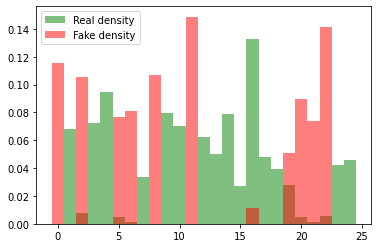

Score: 0.0


In [115]:
score,  _, _ = calculate_prd_score(lr_data, dc_fake_data)
print("Score:", score)

Now use PRD score to compare high resolution data generated from real low resolution data (`sr_fake_data_from_real_lr`) and fake resolution data (`sr_fake_data_from_fake_lr`):

In [ ]:
# print("Generated from real LR")
# score_real, alpha_real, beta_real = calculate_prd_score(hr_data, sr_fake_data_from_real_lr)
# print("Score:", score_real, end='\n\n')

# print("Generated from fake LR")
# score_fake, alpha_fake, beta_fake = calculate_prd_score(hr_data, sr_fake_data_from_fake_lr)
# print("Score:", score_fake, end='\n\n')

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.tick_params(axis="both", which="major", labelsize=8)
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.plot(alpha_real, beta_real, color='g', label="Generated from real LR")
# plt.plot(alpha_fake, beta_fake, color='r', label="Generated from fake LR")
# plt.legend()
# plt.show()

## Fréchet Inception Distance (FID score) (1.0 pts) [cross-check:9]

[Frechet Inception Distance](https://arxiv.org/pdf/1706.08500) is an improved version of [Inception score](https://arxiv.org/abs/1606.03498), that additionally calculates the statistics of real data and compares it to the statistics of generated data. It is probably the most widely-used option for evaluating GANs, and relies on features extracted with [InceptionV3](https://arxiv.org/abs/1512.00567) pretrained on ImageNet. These features assumed to come from a multivariate Gaussian distribution, so Fréchet distance between two multivariate Gaussians can be calculated:

$$\text{FID} = ||\mu_r - \mu_g||^2 + \text{Tr} (\Sigma_r + \Sigma_g - 2 (\Sigma_r \Sigma_g)^{1/2}),$$

where $X_r \sim \mathcal{N} (\mu_r, \Sigma_r)$ and $X_g \sim \mathcal{N} (\mu_g, \Sigma_g)$ are the 2048-dimensional activations of the Inception-v3 pool3 layer for real and generated samples respectively.

First, create InceptionV3 ([from torch repository](https://pytorch.org/hub/pytorch_vision_inception_v3/)) model. As you will be using it for feature extraction only, we should remove last fully connected layer.

In [138]:
class InceptionHeadless(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._upsample = nn.Upsample(scale_factor=2)
        self._model = torch.hub.load(
            'pytorch/vision',
            'inception_v3',
            pretrained=True
        )
        self._model.fc = torch.nn.Identity()  # remove last fc layer
    
    def forward(self, z):
        x = z.permute(0, 3, 1, 2)
        x = self._upsample(x)
        return self._model(x)

In [139]:
inception = InceptionHeadless()
inception.eval()

with torch.no_grad():
    assert inception(lr_data[:32]).shape[1:] == (2048,)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

RuntimeError: ignored

In [135]:
def calculate_activations(
        data: torch.Tensor,
        batch_size: int = 32,
        verbose: bool = False
) -> torch.Tensor:
    # Calculate activations of Pool3 layer of InceptionV3
    if verbose:
        print("Calculating activations...")
    activations = predict(inception, data, batch_size=32)
    return activations

def calculate_activation_statistics(
        activations: torch.Tensor
) -> tp.Tuple[np.array, np.array]:
    activations = activations.numpy().reshape(len(activations), -1)
    # Calculate mean and covariance of activations. Mind the dimensions!
    mu = activations.mean(axis=0)
    t = activations - mu
    sigma = (t.T @ t) / t.shape[0]
    return mu, sigma

In [137]:
real_activations = calculate_activations(lr_data, verbose=True)
real_mu, real_sigma = calculate_activation_statistics(real_activations)

assert real_mu.shape == (2048,)
assert real_sigma.shape == (2048, 2048)

Calculating activations...


NameError: ignored

In [ ]:
import scipy

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    sigma1_sigma2 = scipy.linalg.sqrtm(np.dot(sigma1, sigma2))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(sigma1_sigma2):
        sigma1_sigma2 = sigma1_sigma2.real

    # Product might be almost singular
    if not np.isfinite(sigma1_sigma2).all():
        offset = np.eye(sigma1.shape[0]) * eps
        sigma1_sigma2 = scipy.linalg.sqrtm(np.dot(sigma1 + offset, sigma2 + offset))

    diff = mu1 - mu2
    
    # use diff, sigma1, sigma2 to calculate FID according to the formula above
    return  # TODO: implement score from paper


def calculate_fid_score(real_data, fake_data, verbose=False):
    # Run inception on real and fake data to obtain activations
    real_activations = # TODO
    fake_activations = # TODO

    # Calculate mu and sigma for both real and fake activations
    real_mu, real_sigma = # TODO
    fake_mu, fake_sigma = # TODO

    return calculate_frechet_distance(real_mu, real_sigma, fake_mu, fake_sigma) # calculate Frechet distance

Calculate FID score between `hr_data` and `sr_fake_data_from_real_hr`:

In [ ]:
score = calculate_fid_score(hr_data, sr_fake_data_from_real_lr)
print("Score:", score)

Putting it all together: calculate FID score between `hr_data` and `sr_fake_data_from_fake_hr`:

In [ ]:
score = calculate_fid_score(hr_data, sr_fake_data_from_fake_lr)
print("Score:", score)